## Building blocks of life

In [44]:
import cobra
from qbio_resources.plotting_functions import substrate_name_to_rxn, plot_theoretical_yields
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

In [26]:
def run_and_plot_simulations(cons_model, target_rxn, aerobic=True):
    yield_list = []
    substrate_list = []
    rxn_count = []
    if target_rxn.startswith("EX_"):
        target_met = target_rxn.replace('EX_', '')
        
    for met, met_id in substrate_name_to_rxn.items():

        model.objective = target_rxn
        model.reactions.ATPM.lower_bound = 0
        model.reactions.EX_o2_e.lower_bound = -1000 if aerobic else 0
        model.reactions.EX_glc__D_e.lower_bound = 0

        model.reactions.get_by_id(met_id).lower_bound = -10
        sol = cobra.flux_analysis.pfba(model)

        if sol.x_dict['EX_co2_e'] < -1e-4:
            co2_correction = abs(sol.x_dict['EX_co2_e']) *\
                             model.metabolites.co2_e.elements['C']
            print(met, sol.x_dict['EX_co2_e'])
        else:
            co2_correction = 0

        model.reactions.get_by_id(met_id).lower_bound = 0

        if abs(sol.f) < .001 or abs(sol.x_dict[met_id]) < .001:
            rxn_count.append(0)
            yield_list.append(0)
            substrate_list.append(met)

            continue
        
        if target_rxn not in ['ATPM', model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id]:

            carbon_yield = (sol.f * model.metabolites.get_by_id(target_met).elements['C'] - co2_correction) / \
                           (abs(sol.x_dict[met_id]) * model.metabolites.get_by_id(
                               met_id.replace('EX_', '')).elements['C'])
        else:
            carbon_yield = sol.f / (abs(sol.x_dict[met_id]) * model.metabolites.get_by_id(
                               met_id.replace('EX_', '')))

        count = 0
        for r, v in sol.x_dict.items():
            if abs(v) > 1e-6:
                count += 1

        rxn_count.append(count)
        yield_list.append(carbon_yield)
        substrate_list.append(met)

    plot_theoretical_yields(yield_list, substrate_list, 'Histidine', rxn_count)


## A) Simulating carbon yield of key biomass  for 10 substrates
 - Histidine
 - ATP hydrolysis(using ATPM)
 - Charged SAM (by optimizing artificial SAM methylation reaction)

In [27]:
print(substrate_name_to_rxn)

{'D-Glucose': 'EX_glc__D_e', 'L-Glutamate': 'EX_glu__L_e', 'L-Glutamine': 'EX_gln__L_e', 'D-Ribose': 'EX_rib__D_e', 'L-Lysine': 'EX_lys__L_e', 'D-Lactate': 'EX_lac__D_e', 'L-Aspartate': 'EX_asp__L_e', 'Formate': 'EX_for_e', 'Adenosine': 'EX_adn_e', 'Acetate': 'EX_ac_e'}


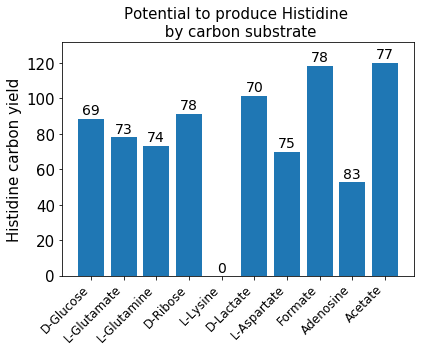

In [47]:
run_and_plot_simulations(model, 'EX_his__L_e', aerobic=True)

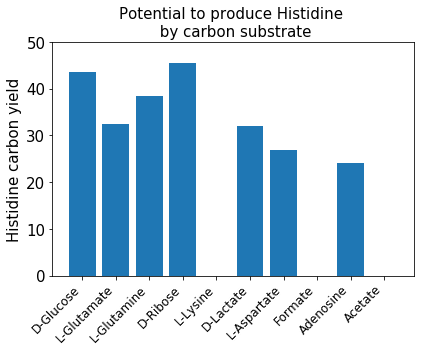

In [13]:
run_and_plot_simulations(model, 'EX_his__L_e', aerobic=False)

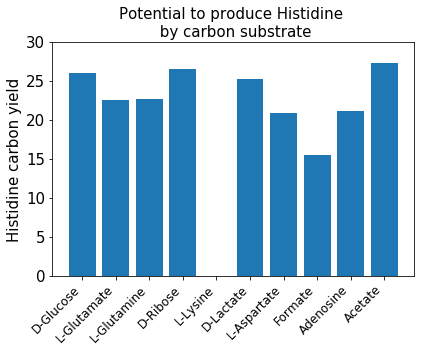

In [14]:
run_and_plot_simulations(model, 'ATPM', aerobic=True)

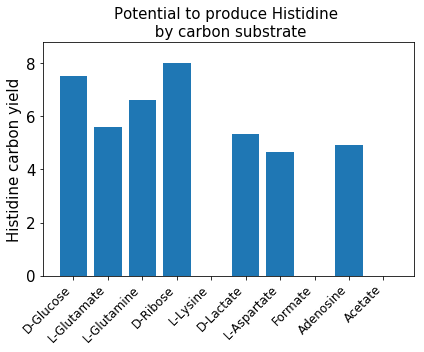

In [15]:
run_and_plot_simulations(model, 'ATPM', aerobic=False)

Ignoring reaction 'EX_amet_c' since it already exists.


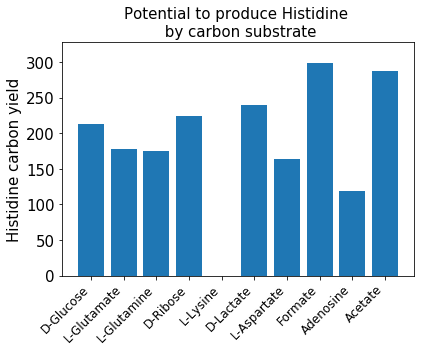

In [16]:
r = cobra.Reaction('EX_amet_c')
model.add_reaction(r)
r.add_metabolites({model.metabolites.amet_c: -1})
run_and_plot_simulations(model, model.reactions.EX_amet_c.id, aerobic=True)

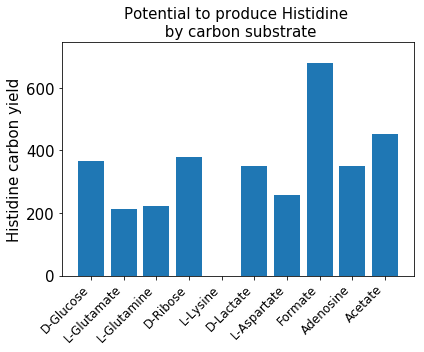

In [17]:
#r = cobra.Reaction('EX_pheme_c')
#model.add_reaction(r)
#r.add_metabolites({model.metabolites.pheme_c_c: -1})
run_and_plot_simulations(model, model.reactions.EX_pheme_e.id, aerobic=True)

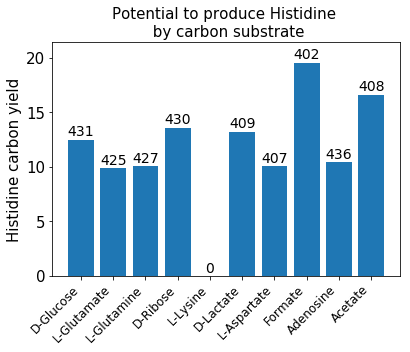

In [20]:
# TODO delete this and maybe mention in the following presentation
run_and_plot_simulations(model, model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id, aerobic=True)

D-Glucose -0.07972457023327631
D-Ribose -0.034547313766963045
D-Lactate -0.007390630328473946


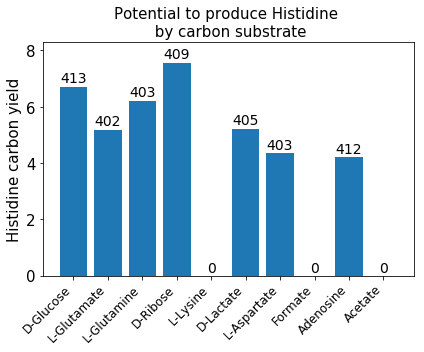

In [12]:
# TODO delete this and maybe mention in the following presentation
run_and_plot_simulations(model, model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id, aerobic=False)

## B) Variability of solutions

In [53]:
model.reactions.EX_glc__D_e.lower_bound = -10
model.optimize()

,fluxes,reduced_costs
ALATA_D2,0.0,-7.751938e-02
SHCHD2,0.0,0.000000e+00
CPPPGO,0.0,-1.860465e+00
GTHOr,0.0,-4.579670e-16
DHORD5,0.0,1.110223e-16
...,...,...
SUCCt1pp,0.0,-0.000000e+00
QUINDH,0.0,-3.100775e-02
LCARSyi,0.0,-3.100775e-02
BIOMASS_Ec_iML1515_core_75p37M,0.0,-1.169092e+01


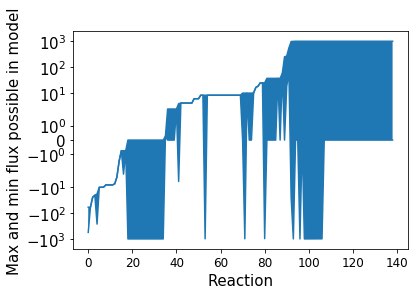

In [54]:
fva = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=1)
plot_list = []
for i, v in zip(fva['maximum'].values,fva['minimum'].values) :
    plot_list.append((i, v))

y1 = []
y2 = []
x_array = []
x=0
for i, v in sorted(plot_list):
    if abs(i)< .001 and abs(v) < 0.001:
        continue
    y1.append(i)
    y2.append(v)
    x_array.append(x)
    x += 1
    
plt.semilogy(x_array, y1, x_array, y2, '#1f77b4')
plt.fill_between(x_array, y1, y2)
plt.fill()
plt.yscale('symlog')
plt.xlabel('Reaction')
plt.ylabel('Max and min flux possible in model')
plt.show()

## C) Sampling the solution space
 - Gives prediction of which reactions/fluxes are most "likely"

In [114]:
model.reactions.EX_his__L_e.lower_bound = model.slim_optimize() * .99
fluxes = cobra.flux_analysis.sampling.sample(model, 100)

In [115]:
fva.T['PFK']

minimum    0.00000
maximum    2.44186
Name: PFK, dtype: float64

In [116]:
variability = fluxes.T[(fluxes.max() - fluxes.min() > 1).values].T

In [117]:
high_variability = variability.T[(variability.max() - variability.min() > 500).values].T 

In [118]:
lower_variability = variability.T[(variability.max() - variability.min() < 5).values].T

In [119]:
lower_variability

,PFK_3,ACALD,FBA,PGL,TALA,GLYAT,GND,G6PDH2r,FBA3,THD2pp,CITt7pp,THRA2,PFK,ATHRDHr,CITt3pp
0,0.128320,4.541479,2.228599,6.494683,-0.703056,4.541206,6.487617,6.494683,0.128320,3.843318,0.000050,4.541369,2.228736,-4.541369,0.000050
1,0.092295,4.537544,2.269321,6.482975,-0.670212,4.537321,6.478072,6.482975,0.092295,3.842877,0.002873,4.537478,2.274293,-4.537478,0.002873
2,0.129074,4.499884,2.235395,6.474510,-0.709901,4.516586,6.469596,6.474510,0.129074,3.831279,0.000287,4.516742,2.239141,-4.516742,0.000287
3,1.550881,0.010230,0.995910,6.022395,-2.288375,-0.016353,6.006701,6.022395,1.550881,0.503338,1.072995,0.023221,1.000072,-0.023221,1.072995
4,1.359760,-0.028176,1.181574,6.043725,-2.089402,-0.010772,6.033233,6.043725,1.359760,0.571698,0.942851,0.028897,1.184155,-0.028897,0.942851
5,1.156009,-0.023301,1.376554,6.065243,-1.878675,-0.018744,6.054639,6.065243,1.156009,0.292150,0.726201,0.022743,1.379115,-0.022743,0.726201
6,1.090382,0.026742,1.372078,6.156728,-1.781987,0.012443,6.151523,6.156728,1.090382,0.235981,0.733455,0.054134,1.372540,-0.054134,0.733455
7,1.077607,-0.003372,1.458843,5.989250,-1.824999,-0.026962,5.981023,5.989250,1.077607,0.392560,0.733645,0.015289,1.459364,-0.015289,0.733645
8,1.158182,0.140194,1.314585,6.178166,-1.842137,0.154519,6.164649,6.178166,1.158182,0.307313,0.472282,0.195748,1.315015,-0.195748,0.472282
9,1.166239,-0.001570,1.319832,6.134788,-1.864214,-0.011685,6.123863,6.134788,1.166239,0.321141,0.438088,0.028180,1.320159,-0.028180,0.438088


(-10, 10)

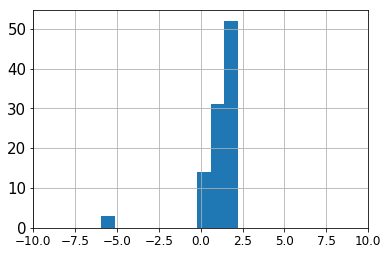

In [121]:
variability['PGI'].hist().set_xlim([-10, 10])

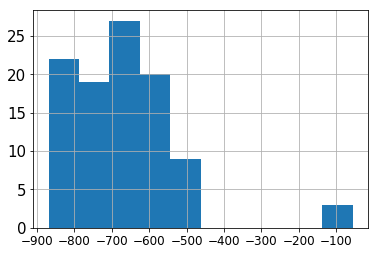

In [122]:
high_variability['PPM'].hist()

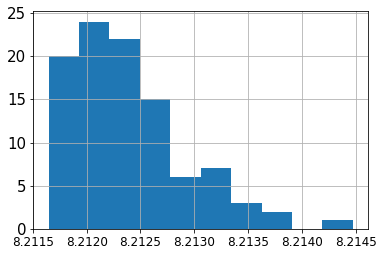

In [124]:
fluxes['EX_his__L_e'].hist()

In [ ]:
fluxes = cobra.flux_analysis.sampling.sample

In [ ]:
fluxes = cobra.flux_analysis.sampling

In [83]:
cobra.flux_analysis.sampling.sample?